In [1]:
import pandas as pd
import numpy as np
from scipy import optimize, stats
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
####################################
# FUNCTION
####################################

def plaw_linerr(xdata,ydata,xerr,yerr,numfits): 
    """
    This function performs linear regression taking into account errors in both X and Y (xerr, yerr).
    It then takes a specificied amount of bootstrap resamples with replacement and repeats the fit.
    It outputs the mean and 1-sigma deviations of the fitted slope.
    numfits is the amount of bootstrap samples.
    """
    # define fit and error function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x))  

    # initial guess
    pinit = [-1.0, 1.0]

    # initiate lists and loop over amount of fits
    ps_amp = []
    ps_ind = []
    scat_dex = []
    
    for i in range(numfits):
        # add random noise to the X,Y data
        randomDeltaX = np.random.normal(0., xerr, len(ydata))
        randomdataX = xdata + randomDeltaX

        randomDeltaY = np.random.normal(0., yerr, len(ydata))
        randomdataY = ydata + randomDeltaY

        # do the fits, calculate mean (ps_amp) and standard deviation (scat_dex) of slope/index and the offset/amplitude 
        randomfit, randomcov = optimize.leastsq(errfunc, pinit, args=(randomdataX, randomdataY), full_output=0)
       
        ps_amp.append(randomfit[0]) 
        ps_ind.append(randomfit[1]) 
        var = np.log10(10**randomdataY/(10**(randomfit[0]+randomdataX*randomfit[1])))                    
        scat_dex.append(np.std(var))

    ps_amp = np.array(ps_amp)
    ps_ind = np.array(ps_ind)
    mean_scat_dex = np.mean(scat_dex)
    std_scat_dex = np.std(scat_dex)
    
    mean_amp, std_amp = np.mean(ps_amp,0), np.std(ps_amp,0)
    mean_ind, std_ind = np.mean(ps_ind,0), np.std(ps_ind,0)

    return mean_amp,mean_ind,std_ind,mean_scat_dex,std_scat_dex,std_amp

In [3]:
####################################
# DATA IMPORT
####################################

# To show routines capabilities we use data from Ochsendorf et al. 2017, ApJ, 841, 2
# from which we will extract star formation rates per free-fall time and molecular cloud masses across the Large Magellanic Cloud

# Read in data and flag zero data
data = pd.read_table('data/table1.txt', delim_whitespace=True,skiprows=25,names=('name','RA','DEC','Type','Mass','Rad','SFR','SFE','SFEff','tff','sigV'),index_col='name') 

In [4]:
####################################
# CALCULATIONS 
####################################

# Limit to nonzero data; transform to logspace
x = np.log10(data['Mass'][data['SFEff'] > 0])
y = np.log10(data['SFEff'][data['SFEff'] > 0])

# Add fiducial errors; here drawn from an (absolute) normal distribution with sigma of 0.2 dex 
errx = np.abs(np.random.normal(0., 0.2, len(x)))
erry = np.abs(np.random.normal(0., 0.2, len(y)))

# Perform linear regression (100 times) to estimate error and robustness of fit given the errors in x and y
x1,x2,x3,x4,x5,x6 = plaw_linerr(x,y,errx,erry,100)

# Calculate Pearson correllation statistics
cor = stats.pearsonr(x,y)

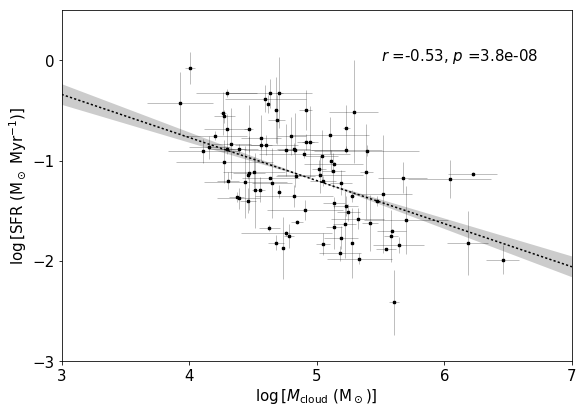

In [8]:
####################################
# PLOT ROUTINES
####################################

xaxis = np.arange(3,8) # x array

fig = plt.figure(figsize=(10.5, 7.5))
font = {'family' : 'normal',
        'weight' : 'normal', 
        'size'   : 15}
plt.rc('font', **font)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.875, top=0.85, wspace=0.35, hspace=0.35)

plt.scatter(x,y, edgecolor='black',facecolor='black', marker='s', s=5, alpha=1,label=r'Type 2',zorder=4)
plt.errorbar(x,y,yerr=errx,xerr=erry,color='black',fmt='.',alpha=0.5,capsize=0,linewidth=0.5)

# plot Pearson's r and p value
plt.text(5.5,0.0,r'$r$ ='+"{0:.2f}".format(cor[0])+', $p$ ='+"{0:.1e}".format(cor[1]),color='black',size=15)

# plot best (i.e. mean) fit and 1-sigma confidence bands
plt.plot(xaxis,x1+xaxis*x2,color='black',linestyle='dotted',linewidth=1.5)
down, up = (x1+x6)+xaxis*(x2-x3), (x1-x6)+xaxis*(x2+x3)
plt.fill_between(xaxis, down,up, facecolor = 'black',alpha=0.2, edgecolor = 'none')

# axes and stuff
axes = plt.gca()
axes.set_xlim([3,7])
axes.set_ylim([-3,0.5])
plt.xlabel(r'log$\,$[$M_\mathrm{cloud}$ (M$_\odot$)]')
plt.ylabel(r'log$\,$[SFR (M$_\odot$ Myr$^{-1}$)]')
plt.locator_params(nbins=4)
    
plt.show()